# <a name="inspection"> Clustering 

## <a name="inspection"> Imports needed for this analysis 

Packages:

* `numpy` is a package for scientific computing in python.
* `pandas` is a package for work with relational or labeled and it is used for data analysis in python.
* `matplotlib` is a package for creating static, animated, and interactive visualizations in Python
* `seaborn` is package for creating for making statistical graphics in python.



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.image as mpimg
import urllib.request
import gdown
from PIL import Image

import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer

In [ ]:
quake_id = '1aUYMWb3aNs43UR7TI_dITzI2T5GttOj1'

gdown.download(f'https://drive.google.com/uc?id={quake_id}', '../data/quake_df.csv', quiet=False)


## <a name="inspection"> 1.0 EDA

* Loading Data

In [6]:
df = pd.read_csv('../data/quake_df.csv')

* Overview of first 5 rows of data

In [7]:
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


After some research data in our table should represent:

1. Focal depth (integer): depth of the earthquake focus.
2. Latitude (float): coordinates of the earthquake location.
3. Longitude (float): coordinates of the earthquake location.
4. Richter (float): Magnitude of the earthquake on the Richter scale.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [9]:
df.shape

(2178, 4)

* Ok for now i see that there is no missing data in the set and data type are  acording to what i see in first few columns.
* Now to see statistics of our data.

In [10]:
df.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


array([[<Axes: title={'center': 'Focal depth'}>,
        <Axes: title={'center': 'Latitude'}>],
       [<Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'Richter'}>]], dtype=object)

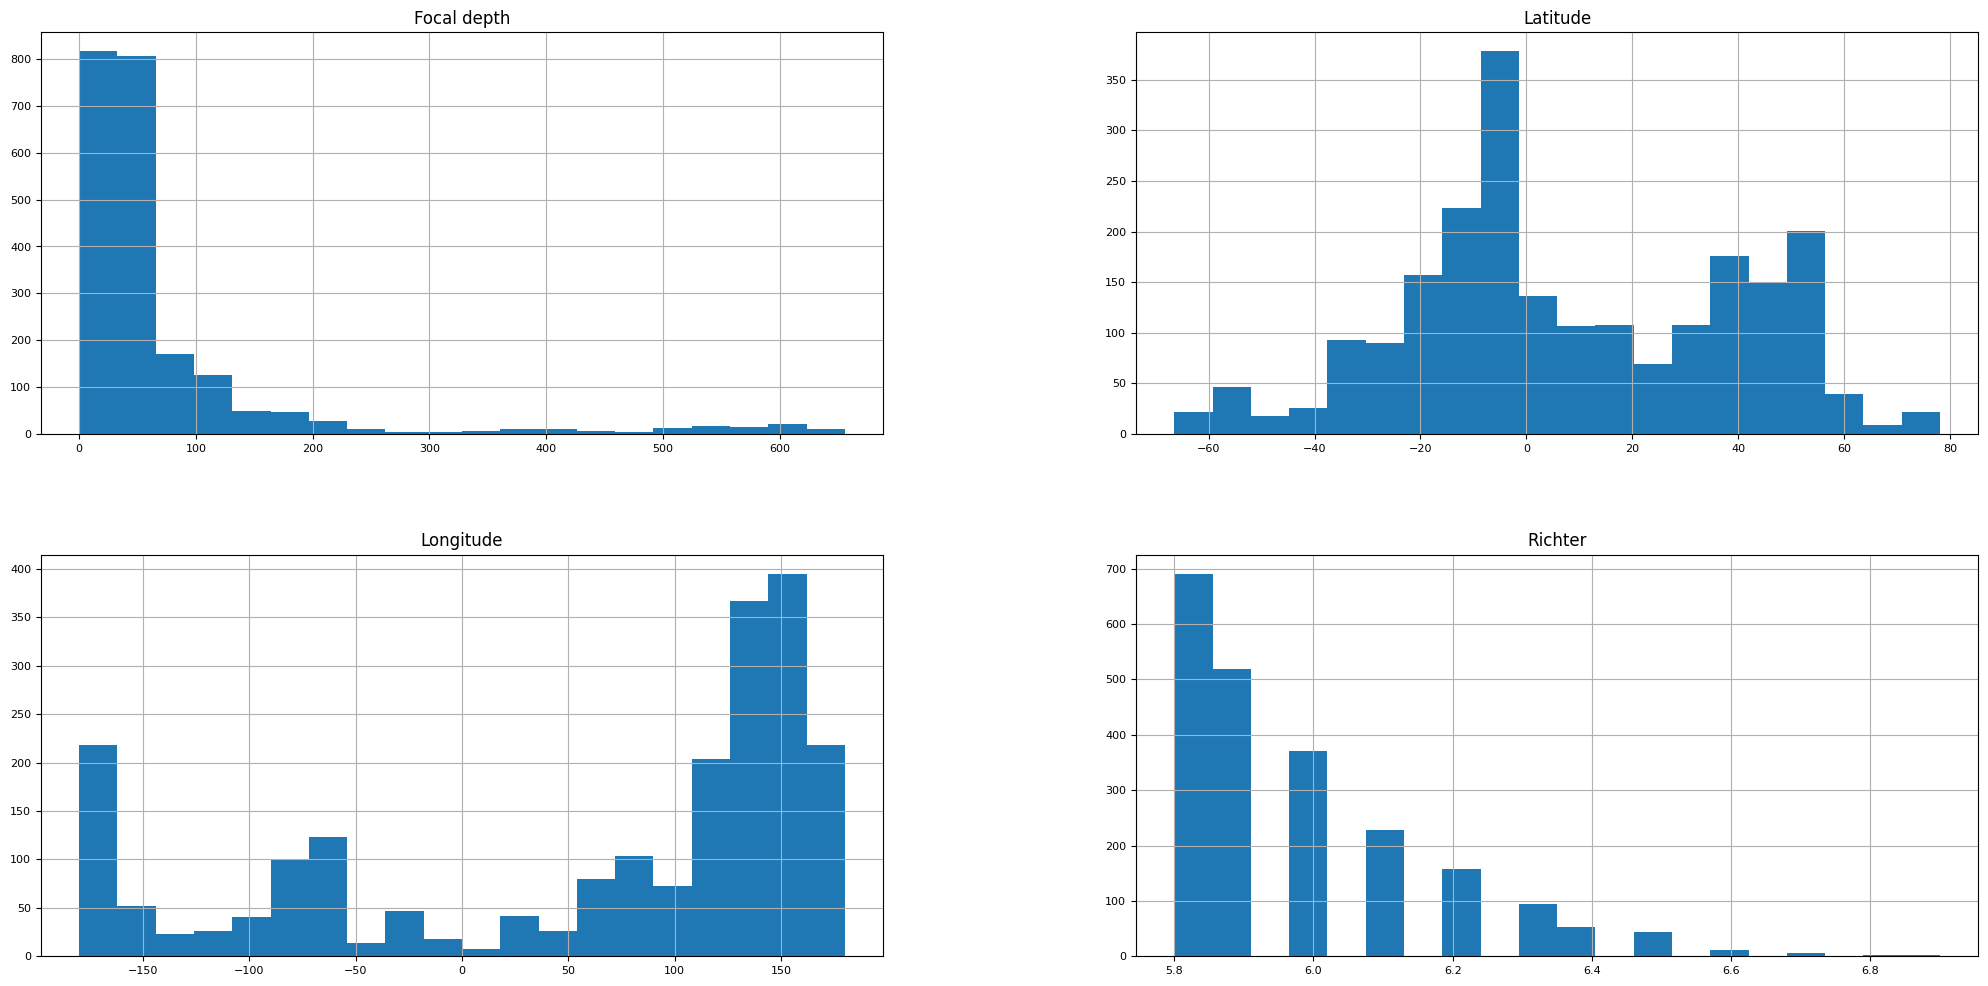

In [11]:
df.hist(figsize=(25, 12), bins=20, xlabelsize=8, ylabelsize=8)

* Checking for outliers.

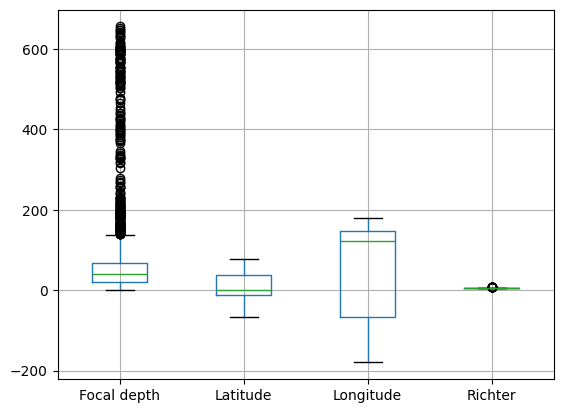

In [12]:
df.boxplot(rot = 0);

In [13]:
fig = px.scatter(df, x='Focal depth', y='Richter', title="2D Visualization of Earthquake instensity in relation to depth")
fig.show()

* After seeing this graph i got confused and curious and researched a little deeper this topic.
* My range of depth is from 0 to 656 and according to [USGS](https://www.usgs.gov/programs/earthquake-hazards/determining-depth-earthquake) there are 3 types of earthquakes:
    1. Shallow: from 0 to 70 (km).
    2. Intermediate: from 70 to 300 (km).
    3. Deep: from 300 to 700 (km).

Therefore at least for K-mean lagorithm i should start with 3 initial centroids.

* Now to use 3D representation

In [14]:
fig = px.scatter_3d(
    df,
    x="Longitude",
    y="Latitude",
    z="Focal depth",
    color="Richter",
    size="Focal depth",
    title="3D Earthquake Plot"
)
fig.show()

* This was experimental since i saw in documentation that this was also available, so wanted to give it a try.

In [19]:
fig = px.scatter_map(
    df,
    lat="Latitude",
    lon="Longitude",
    color="Richter",
    size="Focal depth",
    color_continuous_scale="Viridis",
    size_max=20,
    zoom=0.5,
    title="Earthquake Locations"
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

* Now i will also import image of earth tectonic plates borders and see does earthquakes follow those location. According to data i have and some research i did on institute those borders should have most earthquakes.`

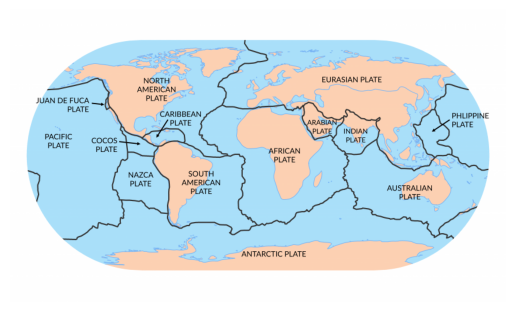

In [20]:
img_url = "https://earthhow.com/wp-content/uploads/2019/01/plate_tectonics_labels-850x502.png"
image = Image.open(urllib.request.urlopen(img_url))
plt.imshow(image)
plt.axis('off')
plt.show()

* Data from mapbox follow the lines from the picture therefore no mistakes in representing them via mapbox have been made.

* Now to see feature corelation

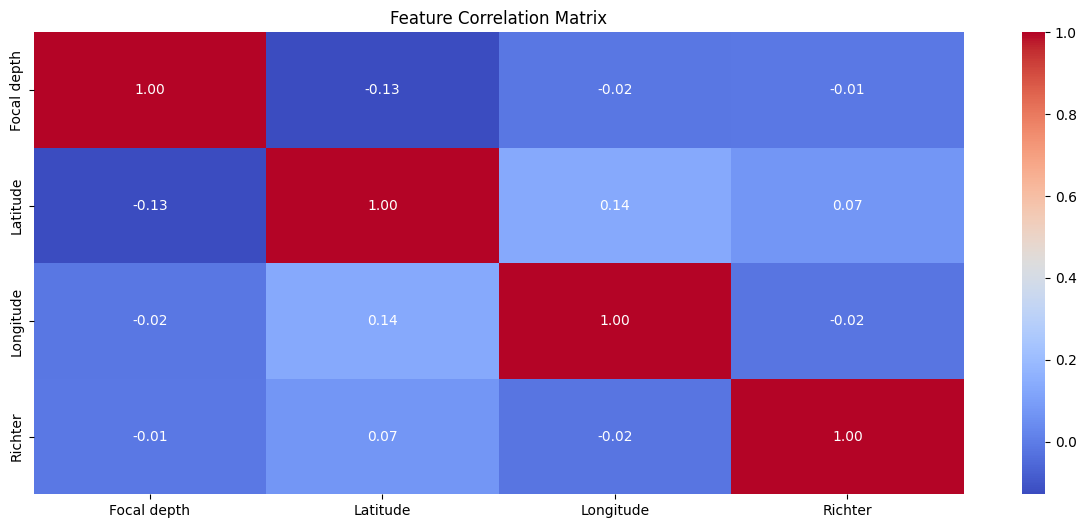

In [21]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.corr('pearson'), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

Conclusion of EDA:

1. Data for depth have uneven distribution and probably because of that have a lot of outliers. Those definetly can affect clustering algorithms especcially K-mean.
2. As for latitude and longitude those data can cause some problems since it represent location on 'sphere like' object and therefore there should be used different aproach to prepare those data.
3. And intensisty (Richter) are also skewed data similarly as focal depth therefore log transformation should help it.
4. No missing data.
5. No highly corelated data.

## <a name="inspection"> 1.1 Data Preparation

<Axes: xlabel='Focal depth', ylabel='Count'>

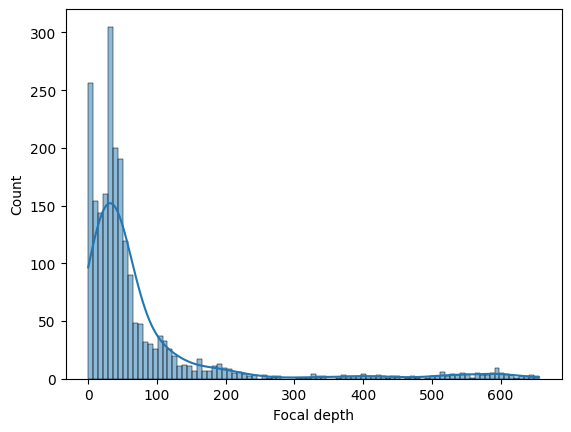

In [22]:
sns.histplot(df["Focal depth"], kde=True)

<Axes: xlabel='Richter', ylabel='Count'>

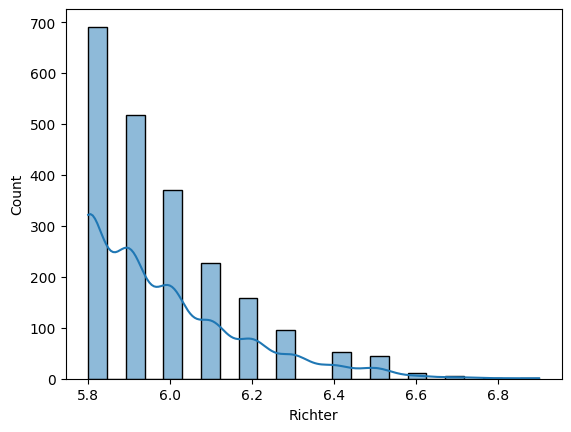

In [23]:
sns.histplot(df['Richter'], kde=True)

In [24]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method='yeo-johnson', standardize=True)
df[['Focal depth_scale']] = scaler.fit_transform(df[['Focal depth']])

* I changed to Yeo-johnson transofrmation due to better profile compared to log.

In [25]:
df['Richter_log'] = np.log1p(df['Richter'])

<Axes: xlabel='Focal depth_scale', ylabel='Count'>

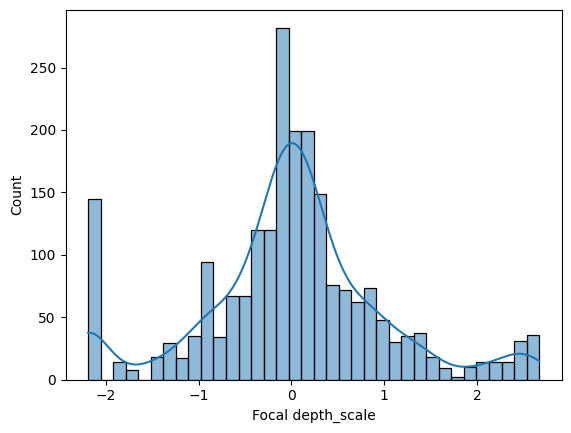

In [26]:
sns.histplot(df['Focal depth_scale'], kde=True)

<Axes: xlabel='Richter_log', ylabel='Count'>

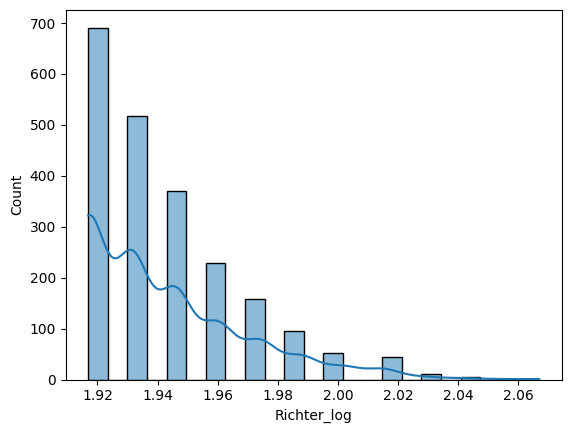

In [27]:
sns.histplot(df['Richter_log'], kde=True)

* Since data distribution of position looks like bimodal  data  iwill try to scale them with robust_scaler.

In [28]:
scaler = RobustScaler()
df[['Latitude_scaled', 'Longitude_scaled']] = scaler.fit_transform(df[['Latitude', 'Longitude']])

<Axes: xlabel='Latitude_scaled', ylabel='Count'>

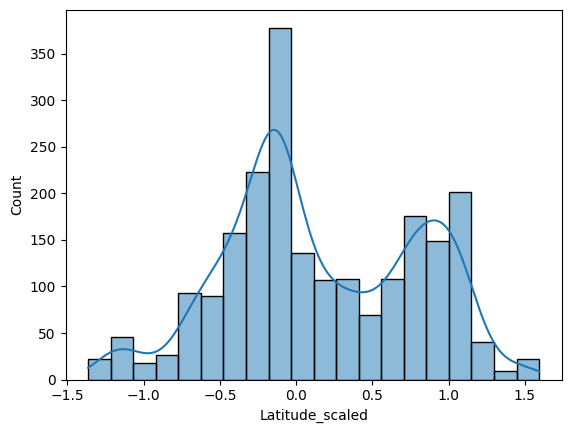

In [29]:
sns.histplot(df['Latitude_scaled'], kde=True)

In [30]:
X = df[["Focal depth_scale", "Richter_log", "Latitude_scaled", "Longitude_scaled"]]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df['pca_x'] = X_pca[:, 0]
df['pca_y'] = X_pca[:, 1]

In [31]:
fig = px.scatter(
    df,
    x='pca_x',
    y='pca_y',
    title="2D PCA Visualization of Earthquake Intensity and Depth",
    labels={'pca_x': 'PCA Focal depth', 'pca_y': 'PCA Richter'},
    hover_data=['Focal depth', 'Richter']
)
fig.show()

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Focal depth        2178 non-null   int64  
 1   Latitude           2178 non-null   float64
 2   Longitude          2178 non-null   float64
 3   Richter            2178 non-null   float64
 4   Focal depth_scale  2178 non-null   float64
 5   Richter_log        2178 non-null   float64
 6   Latitude_scaled    2178 non-null   float64
 7   Longitude_scaled   2178 non-null   float64
 8   pca_x              2178 non-null   float64
 9   pca_y              2178 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 170.3 KB


## <a name="inspection"> 2.0 k-Means Algorithm

In [33]:
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.metrics import silhouette_score
import time

In [34]:
X = df[["Focal depth_scale", "Latitude_scaled", "Longitude_scaled", "Richter_log"]]

kmeans_15 = KMeans(n_clusters=15, random_state=117)
kmeans_15.fit(X)

KMeans(n_clusters=15, random_state=117)

In [35]:
# This part of the code was done for my curiosity
kmeans_3 = KMeans(n_clusters=3, random_state=117)
kmeans_3.fit(X)

KMeans(n_clusters=3, random_state=117)

In [36]:
df["Cluster_15"] = kmeans_15.labels_
df["Cluster_3"] = kmeans_3.labels_
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Focal depth        2178 non-null   int64  
 1   Latitude           2178 non-null   float64
 2   Longitude          2178 non-null   float64
 3   Richter            2178 non-null   float64
 4   Focal depth_scale  2178 non-null   float64
 5   Richter_log        2178 non-null   float64
 6   Latitude_scaled    2178 non-null   float64
 7   Longitude_scaled   2178 non-null   float64
 8   pca_x              2178 non-null   float64
 9   pca_y              2178 non-null   float64
 10  Cluster_15         2178 non-null   int32  
 11  Cluster_3          2178 non-null   int32  
dtypes: float64(9), int32(2), int64(1)
memory usage: 187.3 KB


* Wanted to see how  it looks compared to info about 3 type of earthquakes.

### 2.1 Elbow method for k-Means (15 clusters)

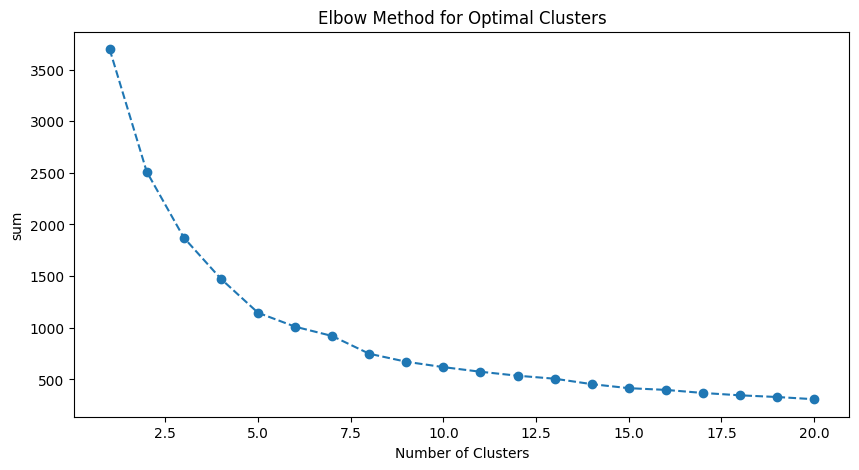

In [37]:
sum = []

for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=117)
    kmeans.fit(X)
    sum.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), sum, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('sum')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

* So optimal number of clustershould be around 6-6.5

### 2.2 Silhouette Score

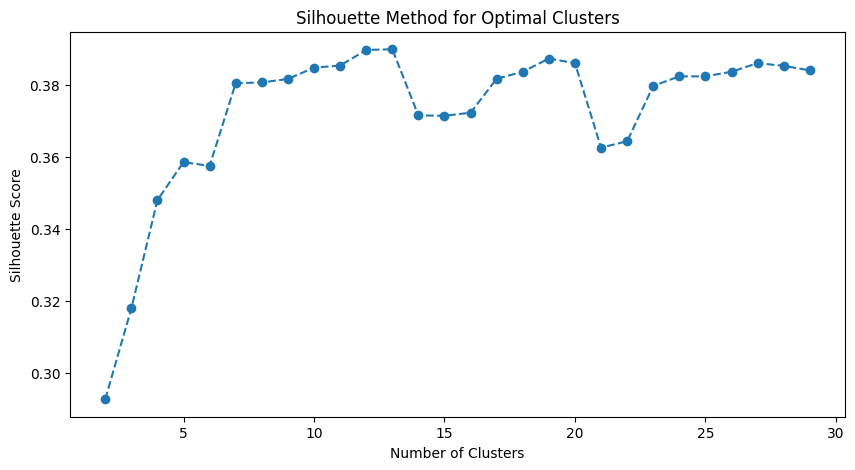

In [38]:
sil_scores = []

for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, random_state=10)
    kmeans.fit(X)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(X, labels))

plt.figure(figsize=(10, 5))
plt.plot(range(2, 30), sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal Clusters')
plt.show()

* Here it starting tostabilizearound 8-9 number of clusters.

In [39]:
kmeans_8 = KMeans(n_clusters=8, random_state=117)
kmeans_8.fit(X)

KMeans(random_state=117)

In [40]:
df["Cluster_8"] = kmeans_8.labels_
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Focal depth        2178 non-null   int64  
 1   Latitude           2178 non-null   float64
 2   Longitude          2178 non-null   float64
 3   Richter            2178 non-null   float64
 4   Focal depth_scale  2178 non-null   float64
 5   Richter_log        2178 non-null   float64
 6   Latitude_scaled    2178 non-null   float64
 7   Longitude_scaled   2178 non-null   float64
 8   pca_x              2178 non-null   float64
 9   pca_y              2178 non-null   float64
 10  Cluster_15         2178 non-null   int32  
 11  Cluster_3          2178 non-null   int32  
 12  Cluster_8          2178 non-null   int32  
dtypes: float64(9), int32(3), int64(1)
memory usage: 195.8 KB


### visualizations

In [41]:
fig = px.scatter(
    df,
    x='pca_x',
    y='pca_y',
    color='Cluster_15',
    title="2D PCA Visualization of Earthquake Intensity and Depth (fort 15 clusters)",
    labels={'pca_x': 'PCA Focal depth', 'pca_y': 'PCA Richter'},
    hover_data=['Focal depth', 'Richter']
)
fig.show()

In [42]:
fig = px.scatter(
    df,
    x='pca_x',
    y='pca_y',
    color='Cluster_8',
    title="2D PCA Visualization of Earthquake Intensity and Depth (for 8 clusters)",
    labels={'pca_x': 'PCA Focal depth', 'pca_y': 'PCA Richter'},
    hover_data=['Focal depth', 'Richter']
)
fig.show()

In [43]:
fig = px.scatter(
    df,
    x='pca_x',
    y='pca_y',
    color='Cluster_3',
    title="2D PCA Visualization of Earthquake Intensity and Depth (for 3 clusters)",
    labels={'pca_x': 'PCA Focal depth', 'pca_y': 'PCA Richter'},
    hover_data=['Focal depth', 'Richter']
)
fig.show()

### 2.3 Minibatch approach compare to k-means

In [44]:
# Standard k-Means
start_kmeans = time.time()
kmeans = KMeans(n_clusters=15, random_state=117, n_init=15)
kmeans.fit(X)
end_kmeans = time.time()

# Mini-Batch k-Means
start_mb_kmeans = time.time()
mb_kmeans = MiniBatchKMeans(n_clusters=15, random_state=117, init='k-means++', n_init=10, batch_size=250)
mb_kmeans.fit(X)
end_mb_kmeans = time.time()

# Compare runtime
print(f"Standard k-Means_15 Runtime: {end_kmeans - start_kmeans:.2f} seconds")
print(f"Mini-Batch k-Means_15 Runtime: {end_mb_kmeans - start_mb_kmeans:.2f} seconds")

# Compare clustering results (e.g., inertia)
print(f"Standard k-Means_15 Inertia: {kmeans.inertia_}")
print(f"Mini-Batch k-Means_15 Inertia: {mb_kmeans.inertia_}")

Standard k-Means_15 Runtime: 0.29 seconds
Mini-Batch k-Means_15 Runtime: 0.12 seconds
Standard k-Means_15 Inertia: 406.8543030239856
Mini-Batch k-Means_15 Inertia: 439.0891105467911


In [45]:
# Standard k-Means
start_kmeans_8 = time.time()
kmeans_8 = KMeans(n_clusters=12, random_state=117, n_init=15)
kmeans_8.fit(X)
end_kmeans_8 = time.time()

# Mini-Batch k-Means
start_mb_kmeans_8 = time.time()
mb_kmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=117, init='k-means++', n_init=15, batch_size=250)
mb_kmeans_8.fit(X)
end_mb_kmeans_8 = time.time()

# Compare runtime
print(f"Standard k-Means(8 clusters) Runtime: {end_kmeans_8 - start_kmeans_8:.2f} seconds")
print(f"Mini-Batch k-Means(8 clusters) Runtime: {end_mb_kmeans_8 - start_mb_kmeans_8:.2f} seconds")

# Compare clustering results (e.g., inertia)
print(f"Standard k-Means(8 clusters) Inertia: {kmeans_8.inertia_}")
print(f"Mini-Batch k-Means(8 clusters) Inertia: {mb_kmeans_8.inertia_}")

Standard k-Means(8 clusters) Runtime: 0.28 seconds
Mini-Batch k-Means(8 clusters) Runtime: 0.10 seconds
Standard k-Means(8 clusters) Inertia: 511.811743407088
Mini-Batch k-Means(8 clusters) Inertia: 806.7342828728105


* So mini batch approach have faster computation time but slightly higher inertia compared to k-means.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Focal depth        2178 non-null   int64  
 1   Latitude           2178 non-null   float64
 2   Longitude          2178 non-null   float64
 3   Richter            2178 non-null   float64
 4   Focal depth_scale  2178 non-null   float64
 5   Richter_log        2178 non-null   float64
 6   Latitude_scaled    2178 non-null   float64
 7   Longitude_scaled   2178 non-null   float64
 8   pca_x              2178 non-null   float64
 9   pca_y              2178 non-null   float64
 10  Cluster_15         2178 non-null   int32  
 11  Cluster_3          2178 non-null   int32  
 12  Cluster_8          2178 non-null   int32  
dtypes: float64(9), int32(3), int64(1)
memory usage: 195.8 KB


## <a name="inspection"> 3.0 DBSCAN Algorithm

In [47]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

* Before using this model i need to choose epsilon parameter and min number of neighbouring points.
With nearest neighobrs we are looking  how distance change between points and chose epsilon parameter based on elbow approach.  

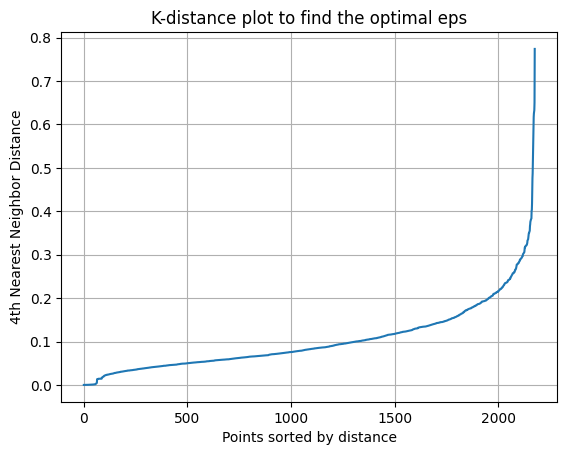

In [48]:
neighbours = NearestNeighbors(n_neighbors=4)
nbrs = neighbours.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,3]
plt.plot(distances)
plt.title('K-distance plot to find the optimal eps')
plt.xlabel('Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

* I should look value between 0.15 and 0.2 for epsilon. below this distances are  not changing a lot which pointing out that they stay close to each others.

In [49]:
# Setting parameters based on graph above!
dbscan = DBSCAN(eps=0.16, min_samples=4)

df['DBSCAN_Cluster'] = dbscan.fit_predict(X)

In [50]:
fig = px.scatter(
                df,
                x='pca_x',
                y='pca_y',
                color='DBSCAN_Cluster',
                title="DBSCAN Clustering Visualization with PCA",
                labels={'pca_x': 'Principal Component 1',
                        'pca_y': 'Principal Component 2',
                        'DBSCAN_Cluster': 'Cluster ID'},
                hover_data=['Focal depth', 'Richter'])

fig.update_traces(marker=dict(size=6, opacity=0.6), selector=dict(mode='markers'))

fig.show()

* Well based on what i learned about earthquakes and performance on this data (assuming i didn't make big mistakes) K-means especially if forced to given numbers do better compared to DBSCAN. Even after tunning parameters of epsilon-radius and # of neighbouring data.

## <a name="inspection"> 3.1 Agglomerative Clustering

In [51]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV

* This time i will try default of 15 then reduce number of clusters to 3 and in last part if i have enough time ill try grid search for best params.

In [52]:
# 15 clusters
agg_clustering = AgglomerativeClustering(
    n_clusters = 15,
    linkage = 'average',
    metric = 'euclidean',
    distance_threshold = None
)

df['Agglomerative_Cluster_simple_15'] = agg_clustering.fit_predict(X)

In [53]:
fig = px.scatter(
                df,
                x='pca_x',
                y='pca_y',
                color='Agglomerative_Cluster_simple_15',
                title="Agglomerative Clustering Visualization with PCA (15 clusters)",
                labels={'pca_x': 'Principal Component 1',
                        'pca_y': 'Principal Component 2',
                        'DBSCAN_Cluster': 'Cluster ID'},
                hover_data=['Focal depth', 'Richter'])

fig.update_traces(marker=dict(size=6, opacity=0.6), selector=dict(mode='markers'))

fig.show()

In [54]:
# 3 clusters
agg_clustering = AgglomerativeClustering(
    n_clusters = 3,
    linkage = 'average',
    metric = 'euclidean',
    distance_threshold = None
)

df['Agglomerative_Cluster_simple_3'] = agg_clustering.fit_predict(X)

In [55]:
fig = px.scatter(
                df,
                x='pca_x',
                y='pca_y',
                color='Agglomerative_Cluster_simple_3',
                title="Agglomerative Clustering Visualization with PCA (3 clusters)",
                labels={'pca_x': 'Principal Component 1',
                        'pca_y': 'Principal Component 2',
                        'DBSCAN_Cluster': 'Cluster ID'},
                hover_data=['Focal depth', 'Richter'])

fig.update_traces(marker=dict(size=6, opacity=0.6), selector=dict(mode='markers'))

fig.show()

* It classified good the deepest earthquakes but it  completly failed on intermediate and shallowed ones! Different approach should be researched!

* Grid implementation.

In [58]:
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean'],
    'distance_threshold': [None],
}

agg_clustering = AgglomerativeClustering()

def silhouette_scorer(estimator, X):
  cluster_labels = estimator.fit_predict(X)
  return silhouette_score(X, cluster_labels)


grid_search = GridSearchCV(estimator=agg_clustering,
                           param_grid=param_grid,
                           cv=3,
                           scoring=silhouette_scorer)

grid_search.fit(X)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_

df['Agglomerative_Cluster'] = best_model.fit_predict(X)

silhouette = silhouette_score(X, df['Agglomerative_Cluster'])
print(f"Silhouette Score: {silhouette}")



Best Hyperparameters: {'distance_threshold': None, 'linkage': 'average', 'metric': 'euclidean', 'n_clusters': 2}
Silhouette Score: 0.43666975403196384


In [57]:
fig = px.scatter(
                df,
                x='pca_x',
                y='pca_y',
                color='Agglomerative_Cluster',
                title="Agglomerative Clustering Visualization with PCA (2 clusters choosen by grid search)",
                labels={'pca_x': 'Principal Component 1',
                        'pca_y': 'Principal Component 2',
                        'DBSCAN_Cluster': 'Cluster ID'},
                hover_data=['Focal depth', 'Richter'])

fig.update_traces(marker=dict(size=6, opacity=0.6), selector=dict(mode='markers'))

fig.show()

Based on this gir search recomended 2 clusters with:

* Average linkage: that means that minimization of average distance is good.
* Manhatan metric: means that this kind of distance calculation is good.
* and number of parameters are set to 2.

Conclusion:

* If i ignore the fact about types of earthquakes and look  only in data     agglomerative and k-means can separate really nicels groups between 2 and 3 cluisters (clearly int  can be seen difference betwen middle and far left and far right data). Espacially agglomerative that separated left part with clear  distance between data.
Now if i try to implement strict number (in this case 3) based on knowledge of earthquake types. K-means really separate it nicely but the range is not good according real world information.

* Therefore the **best** algorithms for this type of data is k-mean when paired with knowledge from real world on types of earthquake to chose number of estimators.

* K-Means: Even thought it inititalize random centroids for this problem it was more easier to control how it cluster data with predefined number of clusters especcialy when paired with real world information. And since the centroids position are updated based on mean value with precise number of centoids to start it gave nice results (not perfect thought).

* DBSCAN: This is based on local density and since data had qute few lokaly  density "centers" (more than 3) and inability to control number of clusters for this particular data set didn't yield good result.

* Agglomerative: Even thought it had different approach from K-mean it gave  good results (slightly off when it was set to 3 clusters compared  to k-means). Probably effect of the data especially if we take into consideration that each point start as its  own cluster and merge based on link criteria.


## Representation

In [60]:
fig = px.scatter_map(
    df,
    lat="Latitude",
    lon="Longitude",
    color="Cluster_3",
    hover_name="Cluster_3",
    size="Focal depth",
    color_continuous_scale="Viridis",
    size_max=25,
    zoom=1.5,
    title="Earthquake Locations"
)
fig.update_layout(mapbox_style="open-street-map")

fig.update_layout(
    width=1750,
    height=680
)

fig.show()